# Customized U-Net Model for Image Segmentation

This model is an adaptation from the original U-Net paper, but it utilizes `DoubleConv` in place of `Conv`.

## 📌 Notebook Structure:

1. **Requirements and Imports**: Setting up the environment.
2. **Model Definition**: Customized U-Net architecture details.
3. **Dataset Definition**: Preprocessing and loading the data.
4. **Training Function**: Implementation of the training loop.
5. **Validation Function**: Checking model performance on unseen data.
6. **Read Data from Google Drive**: Integration with Google Drive for dataset access.
7. **Training Configs and Hyperparameters**: Setting up parameters for optimal training.
8. **Training**: Initiating the model training process.
9. **Validation and Testing**: Evaluating model performance.
10. **Visualize Results**: Displaying segmentation results visually.

In [ ]:
### REQUIREMENTS ###

!pip install -q torch torchvision
!pip install -q PILlow
!pip install -q tqdm
!pip install -q torchinfo
!pip install -q thop

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchinfo import summary
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import random
from multiprocessing import cpu_count
%matplotlib inline
from matplotlib import pyplot as plt
from thop import profile

In [ ]:
### MODEL

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
### DATASET

class SegDataset(Dataset):
    def __init__(self, images_src, masks_src):
        imgs = list(Path(images_src).glob("**/*.jpeg"))
        masks = list(Path(masks_src).glob("**/*.jpeg"))

        imgs = {img.stem: img for img in imgs}
        self.data = [[imgs[mask.stem], mask] for mask in masks if imgs.get(mask.stem)]

        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_src, mask_src = self.data[index]

        image = Image.open(str(image_src))
        mask = Image.open(str(mask_src)).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [ ]:
### TRAIN LOOP

def train(
    model,
    num_epochs,
    patience,
    train_dataloader,
    valid_dataloader,
    save_path,
    loss_fn,
    optimizer,
    scheduler=None,
    device="cpu",
):

    model.to(device)

    num_batch = len(train_dataloader)

    best_loss = 999.0
    best_acc = 0
    num_stop = 0
    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0

        pbar = enumerate(train_dataloader)
        pbar = tqdm(pbar, total=num_batch)
        for i, (images, labels) in pbar:

            # get the inputs
            images = images.to(device, non_blocking=True, dtype=torch.float32)
            labels = labels.to(device, non_blocking=True)

            # zero the parameter gradients
            optimizer.zero_grad()

            # predict classes then apply sigmoid
            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            # compute the loss
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            # backpropagate the loss
            loss.backward()

            # adjust parameters based on the calculated gradients
            optimizer.step()

        # calculate loss
        avg_loss = running_loss/num_batch
        val_loss, val_acc = validate_model(model, valid_dataloader, loss_fn, device)
        val_f1 = val_acc['avg_f1']

        # adjust learning rate using scheduler
        if scheduler is not None:
            scheduler.step()

        # compare loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_acc = val_f1
            torch.save(model.state_dict(), save_path + "/best_model.pth")
            num_stop = 0
        else:
            num_stop += 1

        print(f'[{epoch+1}] loss: {avg_loss:.4f} val-loss: {val_loss:.4f} best: [val-loss: {best_loss:.4f}] | f1-score: {val_f1:.4f} best: [f1-score: {best_acc:.4f}]')

        # early stop
        if num_stop >= patience:
            print(f'No improvement after {patience} epochs since best, stopping...')
            break

        # save model
        torch.save(model.state_dict(), save_path + "/last_model.pth")


In [ ]:
### VALIDATION LOOP

def validate_model(model, valid_dataloader, loss_fn, device="cpu"):
    model.eval()
    running_loss = 0.0

    running_f1 = 0.0
    running_iou = 0.0
    running_mcc = 0.0

    accuracy = {}

    num_batch = len(valid_dataloader)
    n = 0
    with torch.no_grad():
        pbar = enumerate(valid_dataloader)
        pbar = tqdm(pbar, total=num_batch)

        for i, (images, labels) in pbar:

            # get the inputs
            images = images.to(device, non_blocking=True, dtype=torch.float32)
            labels = labels.to(device, non_blocking=True)

            if labels.sum() == 0:
                continue

            n += 1


            # run the model and apply sigmoid
            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            # get validation loss
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            # get acc here
            running_f1 += get_f1(labels, outputs)
            running_iou += get_iou(labels, outputs)
            running_mcc += get_mcc(labels, outputs)


    # compute the loss over all test images
    avg_loss = running_loss / n #num_batch

    avg_f1 = running_f1 / n #num_batch
    avg_iou = running_iou / n #num_batch
    avg_mcc = running_mcc / n #num_batch

    accuracy['avg_f1'] = avg_f1
    accuracy['avg_iou'] = avg_iou
    accuracy['avg_mcc'] = avg_mcc

    return avg_loss, accuracy

def get_f1(label, predict):
    # dice acc
    predict = (predict > 0.5).float()

    intersection = (predict * label).sum()

    f1_acc = (2 * intersection) / (label.sum() + predict.sum() + 1e-8)

    return f1_acc

def get_iou(label, predict):
    predict = (predict > 0.5).float()

    intersection = (predict * label).sum()
    union = label.sum() + predict.sum() - intersection

    return (intersection + 1e-8) / (union + 1e-8)

def get_mcc(label, predict):
    predict = (predict > 0.5).float()

    tp = (predict * label).sum()
    fp = (predict * (1 - label)).sum()
    fn = ((1 - predict) * label).sum()
    tn = ((1 - predict) * (1 - label)).sum()

    numerator = tp * tn - fp * fn
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

    return numerator / (denominator + 1e-8)

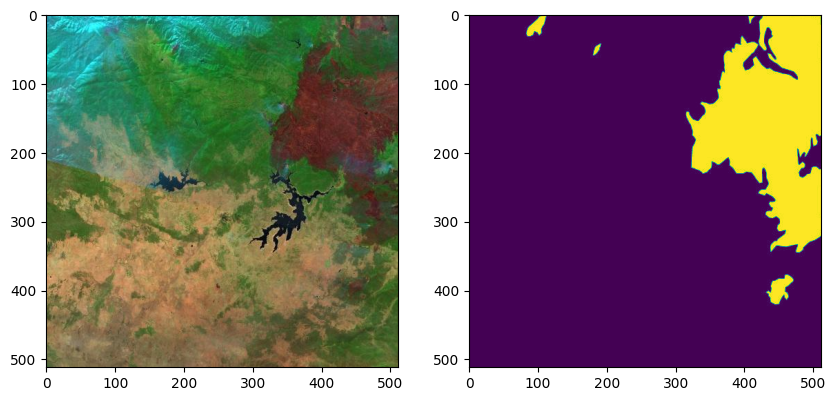

In [ ]:
### READ DATA

IMG_SIZE = 512
BATCH_SIZE = 16
NUM_WORKERS = cpu_count()
ROOT = "/content/drive/MyDrive/ResearchProject/datasets/universal_512_final_final/train_dataset"
MODEL_SAVE_PATH = "/content/drive/MyDrive/ResearchProject/models/u_net"

TRAIN_IMG_DIR = ROOT + "/images/train_images"
TRAIN_MASK_DIR = ROOT + "/masks/train_masks"
VAL_IMG_DIR = ROOT + "/images/val_images"
VAL_MASK_DIR = ROOT + "/masks/val_masks"
TEST_IMG_DIR = ROOT + '/images/test_images'
TEST_MASK_DIR = ROOT + '/masks/test_masks'
VISUAL_IMG_DIR = ROOT + '/images/visual_check_images'
VISUAL_MASK_DIR = ROOT + '/masks/visual_check_masks'

train_dataset = SegDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
valid_dataset = SegDataset(VAL_IMG_DIR, VAL_MASK_DIR)
test_dataset = SegDataset(TEST_IMG_DIR, TEST_MASK_DIR)

random_int = random.randint(0, len(train_dataset))
img, mask = train_dataset[random_int]

img_np = img.numpy().transpose(1, 2, 0)
mask_np = mask.numpy().squeeze()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.subplot(1, 2, 2)
plt.imshow(mask_np)
plt.show()

train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=True
)

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              pin_memory=True
)

test_dataloader = DataLoader(test_dataset,
                              batch_size=1,
                              num_workers=NUM_WORKERS,
                              pin_memory=True
)

In [ ]:
### START TRAINING

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("using CUDA")
else:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("using MPS")
    else:
        device = torch.device("cpu")
        print("using CPU")


model = UNet(3, 1)
load = True
if load:
    model.load_state_dict(torch.load(MODEL_SAVE_PATH + '/best_model.pth'))

summary(model, (BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))

using CUDA


Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [16, 1, 512, 512]         --
├─DoubleConv: 1-1                             [16, 64, 512, 512]        --
│    └─Sequential: 2-1                        [16, 64, 512, 512]        --
│    │    └─Conv2d: 3-1                       [16, 64, 512, 512]        1,728
│    │    └─BatchNorm2d: 3-2                  [16, 64, 512, 512]        128
│    │    └─ReLU: 3-3                         [16, 64, 512, 512]        --
│    │    └─Conv2d: 3-4                       [16, 64, 512, 512]        36,864
│    │    └─BatchNorm2d: 3-5                  [16, 64, 512, 512]        128
│    │    └─ReLU: 3-6                         [16, 64, 512, 512]        --
├─Down: 1-2                                   [16, 128, 256, 256]       --
│    └─Sequential: 2-2                        [16, 128, 256, 256]       --
│    │    └─MaxPool2d: 3-7                    [16, 64, 256, 256]        --
│    │    └

In [ ]:
input_tensor = torch.randn(1, 3, 512, 512).to('cuda')
flops, params = profile(model, inputs=(input_tensor,))
print(f"Flops: {flops:,}, Params: {params:,}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
Flops: 218,951,057,408.0, Params: 31,037,633.0


In [ ]:
NUM_EPOCHS = 500
PATIENCE = 100
LEARNING_RATE_0 = 0.001
LEARNING_RATE_F = LEARNING_RATE_0 * 0.1
WEIGHT_DECAY = 1e-4
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE_0, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = NUM_EPOCHS, eta_min=LEARNING_RATE_F)

train(
    model=model,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    save_path = MODEL_SAVE_PATH,
    loss_fn = loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
)

In [ ]:
### VALIDATION DATASET EVALUATION
loss_fn = nn.MSELoss()
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              pin_memory=True
)
val_loss, val_acc = validate_model(model, valid_dataloader, loss_fn, device)

print(f"Validation loss: {val_loss:.4f}")
for k, v in val_acc.items():
    print(f"Validation {k}: {v:.4f}")

100%|██████████| 18/18 [00:03<00:00,  5.38it/s]

Validation loss: 0.0190
Validation avg_f1: 0.7873
Validation avg_iou: 0.6605
Validation avg_mcc: 0.7755


In [ ]:
### TEST DATASET EVALUATION
test_dataloader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              pin_memory=True
)
test_loss, test_acc = validate_model(model, test_dataloader, loss_fn, device)

print(f"Test loss: {test_loss:.4f}")
for k, v in test_acc.items():
    print(f"Test {k}: {v:.4f}")

100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


Test loss: 0.0124
Test avg_f1: 0.8431
Test avg_iou: 0.7343
Test avg_mcc: 0.8353


  0%|          | 0/6 [00:00<?, ?it/s]

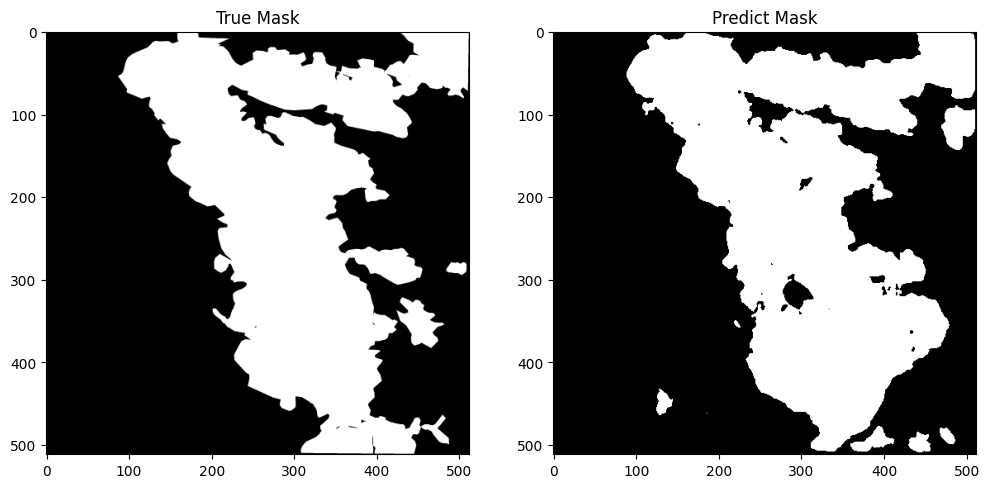

 17%|█▋        | 1/6 [00:01<00:06,  1.29s/it]

F1-score:  0.91464096


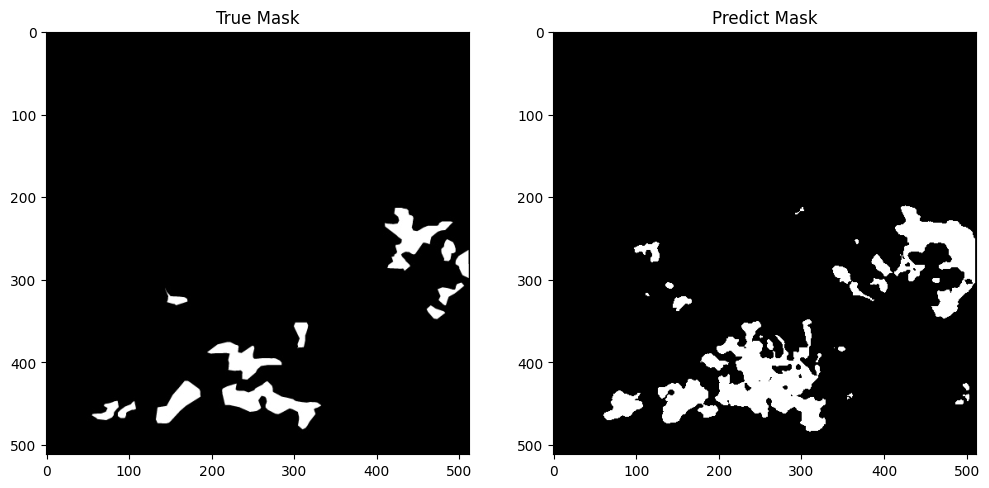

 33%|███▎      | 2/6 [00:01<00:03,  1.32it/s]

F1-score:  0.61090624


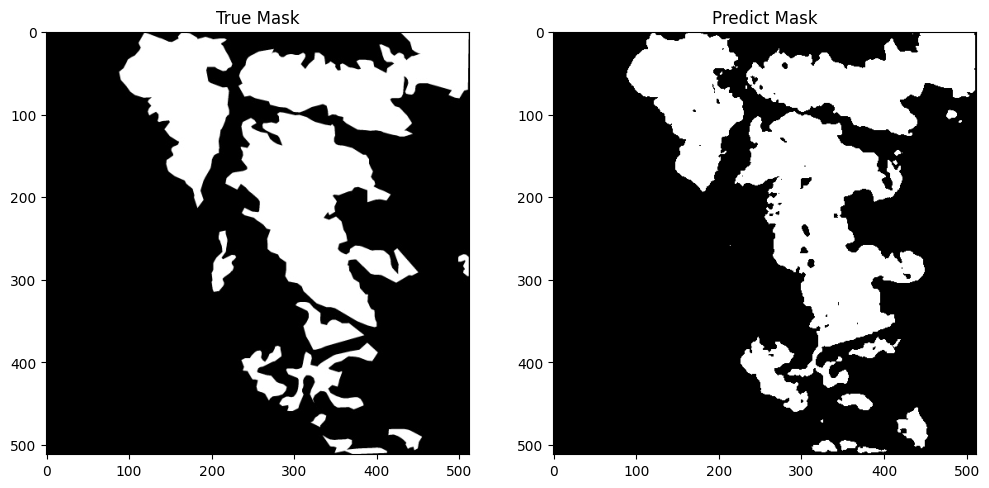

 50%|█████     | 3/6 [00:02<00:01,  1.51it/s]

F1-score:  0.8848617


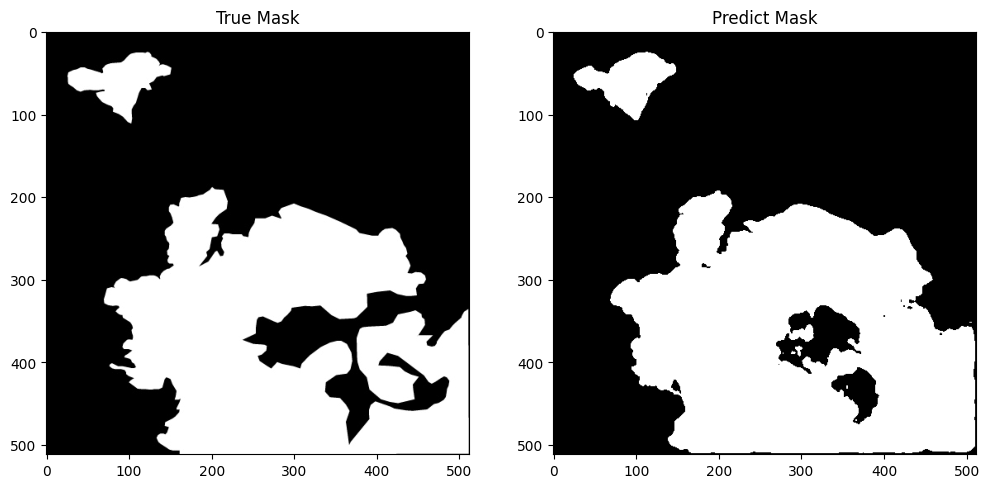

 67%|██████▋   | 4/6 [00:02<00:01,  1.80it/s]

F1-score:  0.93416446


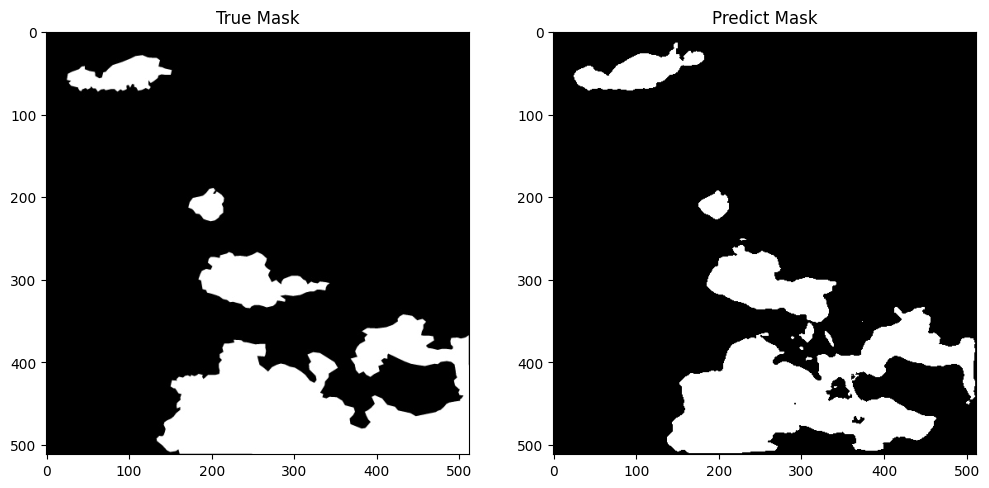

 83%|████████▎ | 5/6 [00:02<00:00,  2.04it/s]

F1-score:  0.8301449


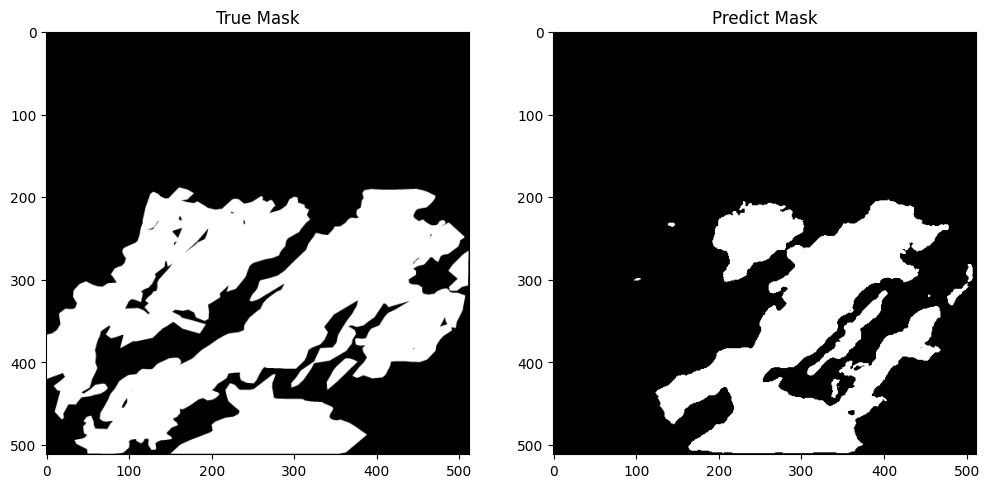

100%|██████████| 6/6 [00:03<00:00,  1.71it/s]

F1-score:  0.6420094


In [ ]:
### VISUALIZE SAMPLE IMAGES PREDICTIONS

VISUAL_IMG_DIR = ROOT + '/images/visual_check_images'
VISUAL_MASK_DIR = ROOT + '/masks/visual_check_masks'
visual_dataset = SegDataset(VISUAL_IMG_DIR, VISUAL_MASK_DIR)
visual_dataloader = DataLoader(visual_dataset,
                              batch_size=1,
                              num_workers=NUM_WORKERS,
                              pin_memory=True
)

def visualize_mask_and_predict(label, predict):
    predict = (predict > 0.5).astype(int)

    label = label.reshape(512, 512)
    predict = predict.reshape(512, 512)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(label, cmap='gray')
    plt.title('True Mask')

    plt.subplot(1, 2, 2)
    plt.imshow(predict, cmap='gray')
    plt.title('Predict Mask')

    plt.show()

with torch.no_grad():
    for data in tqdm(visual_dataloader):

        images, labels = data
        images = images.to(device, non_blocking=True, dtype=torch.float32)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        outputs = torch.sigmoid(outputs)

        labels_np = labels.cpu().numpy()
        outputs_np = outputs.cpu().numpy()

        visualize_mask_and_predict(labels_np, outputs_np)

        # get acc here
        print("F1-score: ", get_f1(labels, outputs).cpu().numpy())